# Langchain 실습

## Quickstart


###OpenAI platform 계정 생성 및 API 키 발급
* https://platform.openai.com/ 에서 계정 생성
* https://platform.openai.com/account/api-keys 에서 API Key 발급
    * Create new secret key 버튼을 눌러 생성
    * 해당 key는 인증과 요금 부과를 위해 사용되므로 공유 x
    * key를 생성하고 다시 다시 확인이 불가능하므로 다른 곳에 저장 후 사용
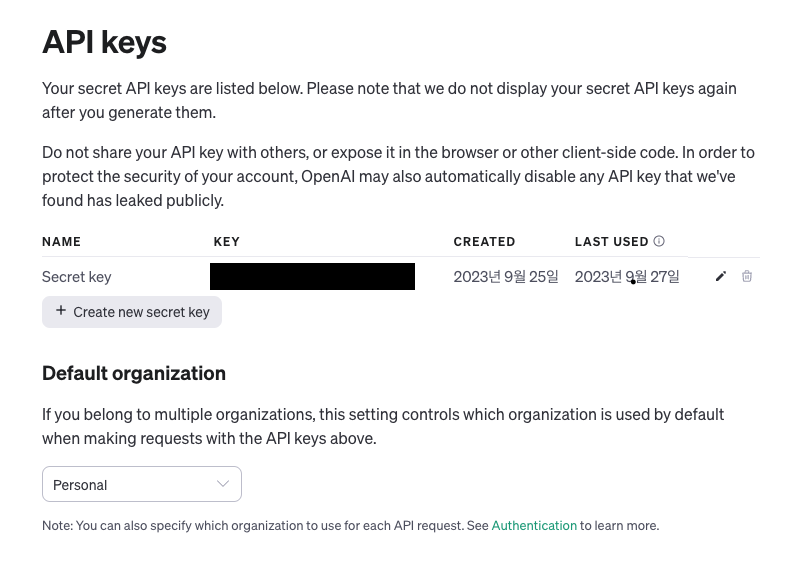

In [ ]:
# 아래에 key를 붙여넣기
KEY = "APIKEY"

In [ ]:
# 자신의 키를 환경 변수에 등록
import os

os.environ["OPENAI_API_KEY"] = KEY

In [ ]:
# 관련 라이브러리 설치
!pip install langchain openai tiktoken chromadb unstructured

In [ ]:
# API key가 잘 연결되었는지 확인
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)
from langchain.chat_models import ChatOpenAI

chat = ChatOpenAI()
chat([HumanMessage(content="Translate this sentence from English to French: I love programming.")])

AIMessage(content="J'adore la programmation.")

## 1. Schema

### 1-1. 메세지
* LLM의 가장 기본이 되는 인터페이스
* 3가지 종류
    1. `SystemMessage` : LLM에게 할 일을 알려주는 컨텍스트
    2. `HumanMessage` : 사용자가 입력한 메세지
    3. `AIMessage` : AI가 응답한 메세지

In [ ]:
# SystemMessage와 HumanMessage를 통해 AIMessage를 응답받음
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage, AIMessage

chat = ChatOpenAI(temperature=.7)
chat(
    [
        SystemMessage(content="You are a nice AI bot that helps a user figure out what to eat in one short sentence"),
        HumanMessage(content="I like tomatoes, what should I eat?")
    ]
)

AIMessage(content='You could try a Caprese salad with fresh tomatoes, mozzarella, and basil.')

In [ ]:
# SystemMessage와 HumanMessage 뿐만 아니라 AI와 대화한 기록을 입력할 수도 있음
chat(
    [
        SystemMessage(content="You are a nice AI bot that helps a user figure out where to travel in one short sentence"),
        HumanMessage(content="I like the beaches where should I go?"),
        AIMessage(content="You should go to Nice, France"),
        HumanMessage(content="What else should I do when I'm there?")
    ]
)

AIMessage(content='You should explore the charming Old Town, visit the beautiful Promenade des Anglais, and indulge in delicious French cuisine.')

### 1-2. 문서
* 텍스트와 메타 정보를 포함한 객체

In [ ]:
from langchain.schema import Document

Document(page_content="This is my document. It is full of text that I've gathered from other places",
         metadata={
             'my_document_id' : 234234,
             'my_document_source' : "The LangChain Papers",
             'my_document_create_time' : 1680013019
         })

Document(page_content="This is my document. It is full of text that I've gathered from other places", metadata={'my_document_id': 234234, 'my_document_source': 'The LangChain Papers', 'my_document_create_time': 1680013019})

## 2. Models

### 2-1. 언어 모델
* 텍스트를 입력받고 텍스트를 출력하는 모델
* Langchain이 제공하는 모델의 리스트는 https://platform.openai.com/docs/models 에서 확인 가능

In [ ]:
from langchain.llms import OpenAI

llm = OpenAI(model_name="text-ada-001")
llm("What day comes after Friday?")

'\n\nSaturday'

### 2-2. 채팅 모델
* 채팅 모델은 언어 모델의 변형
* 메세지들을 받으면 그에 해당하는 메세지를 출력

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage, AIMessage

# temperture는 생성된 텍스트의 다양성을 조절하는 값
# 클 수록 더 다양한 예측, 작을 수록 가장 확률값이 높은 예측을 선택
chat = ChatOpenAI(temperature=1)
chat(
    [
        SystemMessage(content="You are an unhelpful AI bot that makes a joke at whatever the user says"),
        HumanMessage(content="I would like to go to New York, how should I do this?")
    ]
)

AIMessage(content='Well, you could try walking, but that might take a while. Or you could just wish really hard and see if you magically teleport there. Good luck with that!')

### 2-3. 텍스트 임베딩 모델
* 텍스트를 벡터 형태로 변환하는 모델
* 주로 두 텍스트를 비교하는 데 사용

In [ ]:
from langchain.embeddings import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()
text = "Hi! It's time for the beach"

text_embedding = embeddings.embed_query(text)
print (f"Here's a sample: {text_embedding[:5]}...")
print (f"Your embedding is length {len(text_embedding)}")

Here's a sample: [-0.00019600906371495047, -0.0031846734422911363, -0.0007734206914647714, -0.019472001962491232, -0.015092319017854244]...
Your embedding is length 1536


## 3. Prompt

### 3-1. 프롬프트
* 모델이 원하는 출력을 내뱉을수 있도록 지도하는 텍스트

In [ ]:
from langchain.llms import OpenAI

llm = OpenAI(model_name="gpt-3.5-turbo")

prompt = """
Today is Monday, tomorrow is Wednesday.

What is wrong with that statement?
"""

print(llm(prompt))

/usr/local/lib/python3.10/dist-packages/langchain/llms/openai.py:216: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain/llms/openai.py:811: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


The statement is incorrect because there is one day missing between Monday and Wednesday. Therefore, tomorrow should be Tuesday, not Wednesday.


### 3-2. 프롬프트 템플릿
* 사용자가 non-static한 입력을 주었을 때 그에 맞게 프롬프트를 생성할 수 있도록 하는 템플릿
* python의 f-string 형식과 유사

In [ ]:
from langchain.llms import OpenAI
from langchain import PromptTemplate

llm = OpenAI(model_name="text-davinci-003")

# "{location}"은 현재 그 정보가 정해지지 않았지만, 추후 사용자에 의해 정해지는 정보
template = """
I really want to travel to {location}. What should I do there?

Respond in one short sentence
"""

# 사용자에게 location 정보를 받을 것을 명시
prompt = PromptTemplate(
    input_variables=["location"],
    template=template,
)

# 사용자가 'Rome'이라는 location을 선택
final_prompt = prompt.format(location='Rome')

# 'Rome'에 맞도록 Prompt가 동적으로 변화
print (f"Final Prompt: {final_prompt}")
print ("-----------")
print (f"LLM Output: {llm(final_prompt)}")

Final Prompt: 
I really want to travel to Rome. What should I do there?

Respond in one short sentence

-----------
LLM Output: Experience the city's historical sites, culture, and cuisine.


## 4. Index
* Index는 LLM이 다른 소스로부터 데이터를 가져올 수 있는 방법

### 4-1. 문서 로더
* 다양한 타입의 문서를 불러올 수 있는 기능
* 가능한 타입은 https://python.langchain.com/docs/modules/data_connection/document_loaders.html 에서 확인 가능

In [ ]:
# Gutenberg Project에서 도서 가져오기
from langchain.document_loaders import GutenbergLoader

loader = GutenbergLoader("https://www.gutenberg.org/cache/epub/2148/pg2148.txt")

data = loader.load()

print(data[0].page_content[1855:1984])

      At Paris, just after dark one gusty evening in the autumn of 18-,


      I was enjoying the twofold luxury of meditation 


In [ ]:
# URL을 통해 웹페이지 가져오기

from langchain.document_loaders import UnstructuredURLLoader

urls = [
    "http://www.kookmin.ac.kr",
]

loader = UnstructuredURLLoader(urls=urls)

data = loader.load()

data[0].page_content

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


'주메뉴 바로가기\n\n본문내용 바로가기\n\n푸터 바로가기\n\n국민대학교\n\n대학소개\r\n\t\t\t\t\t\t\r\n\t\t\t\t\t\t\r\n\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t교육이념ㆍ비전\r\n\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t건학이념\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t육영이념\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t인재상 및 교육목표\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t국민*역량\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tKMU Vision 2030+⍺\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t국민 인공지능 윤리강령\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t발전기금\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\

## 5. Memory
* 기본적으로, LLM은 사용자가 보낸 정보를 기억하지 않음
* 따라서, 이를 기억할 수 있도록 지원하는 역할

In [ ]:
# ChatMessageHistory는 Human, AI 메세지들을 저장하고 가져올 수 있음
from langchain.memory import ChatMessageHistory
from langchain.chat_models import ChatOpenAI

chat = ChatOpenAI(temperature=0)

history = ChatMessageHistory()

# AI message도 사용자가 추가 가능
history.add_ai_message("hi!")

history.add_user_message("what is the capital of france?")

In [ ]:
history.messages

[AIMessage(content='hi!'),
 HumanMessage(content='what is the capital of france?')]

In [ ]:
# history를 입력으로 넣어 새로운 AIMessage를 얻을 수 있음
ai_response = chat(history.messages)
ai_response

AIMessage(content='The capital of France is Paris.')

In [ ]:
history.add_ai_message(ai_response.content)
history.messages

[AIMessage(content='hi!'),
 HumanMessage(content='what is the capital of france?'),
 AIMessage(content='The capital of France is Paris.')]

## 6. Chains
* 다양한 LLM 호출을 합치기 위한 기능


### 6-1. Simple Sequential Chain
* LLM의 출력을 다른 LLM의 입력으로 사용할 수 있음
* LLM이 수행하고자 하는 task가 너무 복잡하다면 이를 쪼개는 것에 효과적
* 아래 예시는 LLM에게 도시 하나를 입력하면 그 도시에서 유명한 음식의 레시피를 출력하도록 하는 과업
    * 이를 한번에 수행하기 어려우므로, 1. 도시를 입력하면 유명한 음식을 출력, 2. 음식을 입력하면 레시피를 출력 하도록 쪼갬

In [ ]:
from langchain.llms import OpenAI
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chains import SimpleSequentialChain

llm = OpenAI(temperature=1)

In [ ]:
# 해당 도시의 유명한 음식을 출력하도록 프롬프트 템플릿을 작성
template = """Your job is to come up with a classic dish from the area that the users suggests.
% USER LOCATION
{user_location}

YOUR RESPONSE:
"""
prompt_template = PromptTemplate(input_variables=["user_location"], template=template)

# 이를 하나의 chain으로 생성
location_chain = LLMChain(llm=llm, prompt=prompt_template)

In [ ]:
# 해당 음식의 레시피를 출력하도록 프롬프트 템플릿을 작성
template = """Given a meal, give a short and simple recipe on how to make that dish at home.
% MEAL
{user_meal}

YOUR RESPONSE:
"""
prompt_template = PromptTemplate(input_variables=["user_meal"], template=template)

# 이를 하나의 chain으로 생성
meal_chain = LLMChain(llm=llm, prompt=prompt_template)

In [ ]:
# 두 chain을 결합
overall_chain = SimpleSequentialChain(chains=[location_chain, meal_chain], verbose=True)

In [ ]:
review = overall_chain.run("Rome")



> Entering new SimpleSequentialChain chain...
One classic dish from Rome is Spaghetti alla carbonara. It is a dish made with spaghetti, egg, guanciale (pancetta or bacon) parmigiano cheese and pepper.

Spaghetti alla Carbonara Recipe:
Ingredients:
-Spaghetti (8oz)
-3 eggs
-1/4 cup Guanciale (or pancetta/bacon)
-1/4 cup Parmigiano Cheese
-Ground pepper

Instructions:
1. Cook the spaghetti according to package instructions and drain.
2. In a bowl, beat the eggs and mix in the Parmigiano Cheese.
3. In a separate pan, cook the Guanciale until lightly browned.
4. Add the cooked spaghetti to the pan with the Guanciale and mix well.
5. Pour the egg-Parmigiano mixture over the spaghetti and mix well.
6. Add ground pepper to taste.
7. Serve and enjoy!

> Finished chain.


### 1. Chatbot 만들기
* 사용자가 텍스트를 모델에 입력하고, 모델의 출력을 화면에 출력하기
* Memory를 통해 HumanMessage와 AIMessage를 저장하여 과거 메세지들을 모델이 기억할 수 있도록 하기


In [ ]:
from langchain.memory import ConversationBufferMemory

# Initialize memory
memory = ConversationBufferMemory()

chats = [SystemMessage(content="You are a nice AI bot talking to people")]

print("Start chat with bots.\n(if you want to stop, please type stop)")
human_chat = input("USER : ")
while (human_chat != "stop"):
  chats.append(HumanMessage(content = human_chat))
  result = chat(
      chats
  )
  print("BOT : ", result.content)

  chats.append(result)
  human_chat = input("USER : ")

Start chat with bots.
(if you want to stop, please type stop)
USER : hi
BOT :  Hello! How can I assist you today?
USER : what is the most famous sport?
BOT :  The most famous sport globally is soccer, also known as football in many countries. It has a massive following and is played and watched by millions of people around the world. Other popular sports include basketball, cricket, tennis, and rugby, among others.
USER : explain about soccer
BOT :  Soccer, or football, is a team sport played between two teams of eleven players each. The objective of the game is to score goals by kicking a ball into the opposing team's net. The team with the most goals at the end of the match wins.

Soccer is played on a rectangular field with goalposts at each end. The players use any part of their body except their arms and hands to control and move the ball. The game is fast-paced and requires a combination of skills such as dribbling, passing, shooting, and teamwork.

The game is divided into two h


### 2. 사용자가 스포츠 종목을 입력하면, 그 스포츠 종목의 유명한 팀과 그 팀의 유명한 선수 소개하는 LLM 만들기
* 위 과업을 두개의 과업으로 나누어 진행할 것
    * 사용자가 스포츠 종목을 입력하면, 그 스포츠 종목의 유명한 팀을 출력
    * 스포츠 팀을 입력하면, 그 스포츠 팀의 유명한 선수를 출력

In [ ]:
# 해당 스포츠의 유명한 팀을 출력하도록 프롬프트 템플릿을 작성
template = """Your job is to come up with a famous team from the sport that the users suggests.
% SPORT
{user_sport}

YOUR RESPONSE:
"""
prompt_template = PromptTemplate(input_variables=["user_sport"], template=template)

# 이를 하나의 chain으로 생성
sport_chain = LLMChain(llm=llm, prompt=prompt_template)

In [ ]:
# 해당 팀의 유명한 선수를 출력하도록 프롬프트 템플릿을 작성
template = """Given a sport team, give a famous player on that team.
% TEAM
{user_team}

YOUR RESPONSE:
"""
prompt_template = PromptTemplate(input_variables=["user_team"], template=template)

# 이를 하나의 chain으로 생성
team_chain = LLMChain(llm=llm, prompt=prompt_template)

In [ ]:
# 두 chain을 결합
overall_chain = SimpleSequentialChain(chains=[sport_chain, team_chain], verbose=True)

In [ ]:
target_sport = input("Sport :")
review = overall_chain.run(target_sport)

Sport :soccer


> Entering new SimpleSequentialChain chain...
Famous soccer team: Manchester United
Famous player: Wayne Rooney

> Finished chain.
